In [35]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('..')

from algorithms.random_policy import RandomPolicy
from algorithms.sequence_models.decision_sequence_policy import DTPolicy
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from data.random_walk_dataset import RandomWalkDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from envs.random_walk import RandomWalkEnv
from experiment import Experiment
import gymnasium as gym
from functools import partial
from algorithms.evaluate_policy import evaluate_policy
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device is  cuda


In [36]:
from minigrid.wrappers import ImgObsWrapper

inner_env = gym.make('MiniGrid-DoorKey-5x5-v0')
inner_env_human = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='human')
env = ImgObsWrapper(inner_env)
env_human = ImgObsWrapper(inner_env_human)


config = TrainConfig(max_eval_ep_len=env.max_steps, context_len=256,
                     eval_model_interval=50)

#################### todo
# n_trajectories should be at least 10000 for the agent to learn I think 
####################
# todo later also try running with higher n_trajectories
n_trajectories = 10_000
experiment_name = f"experiment_door_key_dataset_size={n_trajectories}"
if DoorKeyDataset.exists(experiment_name):
    traj_dataset = DoorKeyDataset.load(experiment_name)
else:
    traj_dataset = DoorKeyDataset(env, n_trajectories=n_trajectories, reward_scale=1, prob_keeping_nonzero=0.01)
    traj_dataset.save(experiment_name)

dt_model = DecisionTransformer(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    n_blocks=config.n_blocks,
    h_dim=config.embed_dim,
    context_len=config.context_len,
    n_heads=config.n_heads,
    drop_p=config.dropout_p,
).to(device)

make_dt_policy = partial(DTPolicy, model=dt_model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

experiment = Experiment(
    model_name='dt',
    model=dt_model,
    env_name='MiniGrid-DoorKey-5x5-v0',
    env=env,
    experiment_name='increase_context_size',
    traj_dataset=traj_dataset,
    dataset_name=f'size={len(traj_dataset)}',
    config=config,
    device=device,
    eval_policies_and_names=[
        (make_dt_policy(rtg=rtg), f'dt,rtg={rtg:.2f}')
        for rtg in np.linspace(0, 1, 12)
    ]
)

/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_steps` for environment variables or `env.get_wrapper_attr('max_steps')` that will search the reminding wrappers.
  logger.warn(


number of parameters 1159579


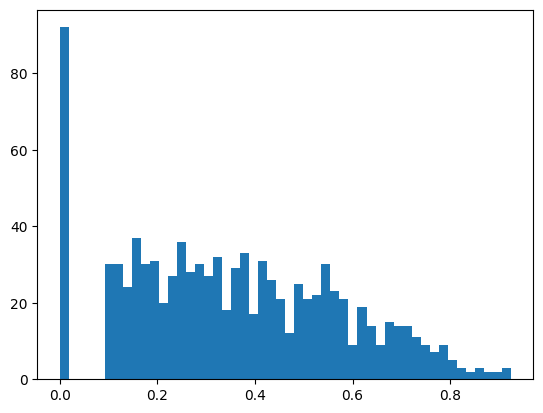

In [37]:
# rewards:
plt.hist([traj.returns[0] for traj in traj_dataset], bins=50);

In [38]:
report = experiment.train_for(600)
experiment.save_fig(f"_rtg_following_learning_process={experiment.custom_callback.iters}")

training started


  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
experiment.plot_loss(report)
experiment.save_fig(f"_loss_after={experiment.custom_callback.iters}")

In [ ]:
# policy = RandomPolicy(env)
policy = make_dt_policy(rtg=1)

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env, num_eval_ep=2)

In [ ]:
# wanna see what's happening? use env_human

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env_human, num_eval_ep=10)

In [ ]:
rtg_commands = np.linspace(0, 1.2, 10)
rtg_results = [evaluate_policy(make_dt_policy(rtg=rtg), env, num_eval_ep=10)['eval/avg_reward']
               for rtg in tqdm(rtg_commands)
               ]
max_in_dataset = max([traj.returns[0] for traj in traj_dataset])

In [ ]:
plt.plot(rtg_commands, rtg_results)
plt.plot(rtg_commands, rtg_commands)
plt.hlines(max_in_dataset, rtg_commands[0], rtg_commands[-1])
plt.xlabel("rtg_command")
plt.xlabel("rtg_result")
plt.legend(["agent", "x=y", "max in dataset"])
experiment.save_fig(f"_rtg_following_iters={experiment.custom_callback.iters}")

In [ ]:
# todo the fancy graph with std and mean?

## TODO: Maybe the context Length is small? Try increasing it!
## TODO: Can we just not use a very large context length?!

# Now S4 model

In [7]:
from algorithms.sequence_models.decision_S4.dts4 import DecisionS4

s4_model = DecisionS4(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    h_dim=config.embed_dim,
    drop_p=config.dropout_p,
).to(device)

make_s4_policy = partial(DTPolicy, model=s4_model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

experiment = Experiment(
    model_name='s4',
    model=s4_model,
    env_name='MiniGrid-DoorKey-5x5-v0',
    env=env,
    experiment_name='increase_context_size',
    traj_dataset=traj_dataset,
    dataset_name=f'size={len(traj_dataset)}',
    config=config,
    device=device,
    eval_policies_and_names=[
        (make_s4_policy(rtg=rtg), f'dt,rtg={rtg:.2f}')
        for rtg in np.linspace(0, 1, 12)
    ]
)

number of parameters 630811


training started


  0%|          | 0/600 [00:00<?, ?it/s]

time elapsed: 0:00:09
num of updates: 100
loss: 0.16027
lr 0.00001
grad_norm 0.12235
time elapsed: 0:00:17
num of updates: 200
loss: 0.14785
lr 0.00002
grad_norm 0.06514
time elapsed: 0:00:25
num of updates: 300
loss: 0.13756
lr 0.00003
grad_norm 0.03265
time elapsed: 0:00:33
num of updates: 400
loss: 0.13170
lr 0.00004
grad_norm 0.02049
time elapsed: 0:00:41
num of updates: 500
loss: 0.12813
lr 0.00005
grad_norm 0.01410
time elapsed: 0:00:50
num of updates: 600
loss: 0.12592
lr 0.00006
grad_norm 0.00964
time elapsed: 0:00:58
num of updates: 700
loss: 0.12462
lr 0.00007
grad_norm 0.00796
time elapsed: 0:01:06
num of updates: 800
loss: 0.12383
lr 0.00008
grad_norm 0.00738
time elapsed: 0:01:14
num of updates: 900
loss: 0.12337
lr 0.00009
grad_norm 0.00707
time elapsed: 0:01:22
num of updates: 1000
loss: 0.12308
lr 0.00010
grad_norm 0.00765
time elapsed: 0:01:30
num of updates: 1100
loss: 0.12288
lr 0.00011
grad_norm 0.00704
time elapsed: 0:01:38
num of updates: 1200
loss: 0.12275
lr 0.0

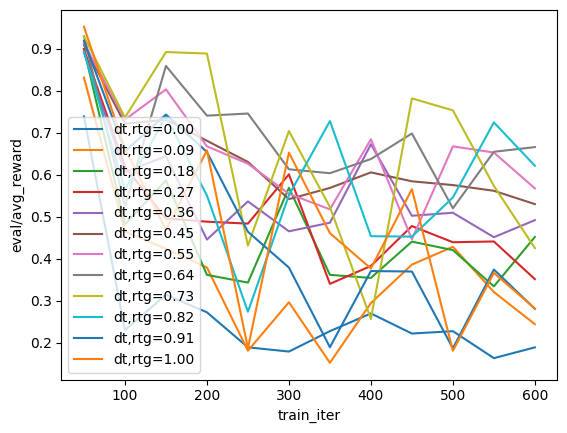

In [8]:
report = experiment.train_for(600)
experiment.save_fig(f"_rtg_following_learning_process={experiment.custom_callback.iters}")

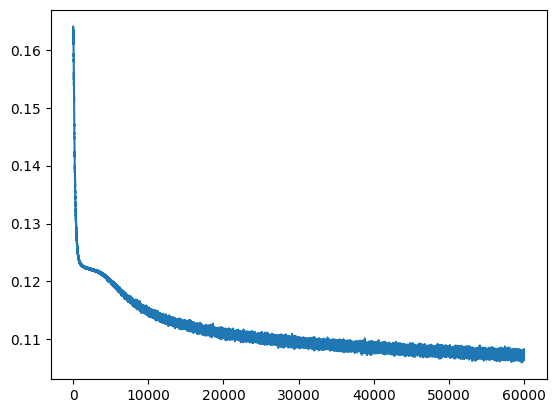

In [9]:
experiment.plot_loss(report)
experiment.save_fig(f"_loss_after={experiment.custom_callback.iters}")

In [26]:
# policy = RandomPolicy(env)
policy = make_s4_policy(rtg=1)

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env, num_eval_ep=30)

{'eval/avg_reward': 0.5012933333333333, 'eval/avg_ep_len': 125.56666666666666}

In [16]:
# wanna see what's happening? use env_human

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env_human, num_eval_ep=10)

{'eval/avg_reward': 0.28164, 'eval/avg_ep_len': 180.1}

In [27]:
rtg_commands = np.linspace(0, 1.2, 10)
rtg_results = [evaluate_policy(make_dt_policy(rtg=rtg), env, num_eval_ep=10)['eval/avg_reward']
               for rtg in tqdm(rtg_commands)
               ]
max_in_dataset = max([traj.returns[0] for traj in traj_dataset])

  0%|          | 0/10 [00:00<?, ?it/s]

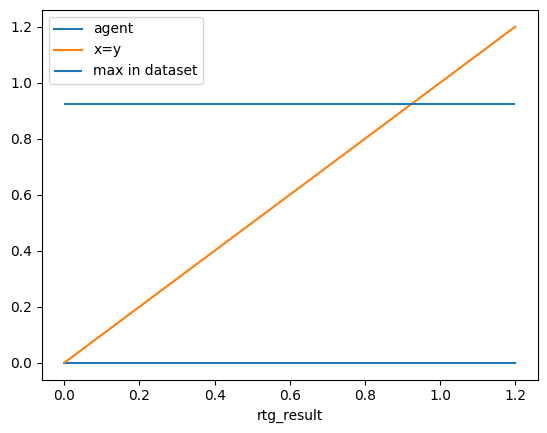

In [28]:
plt.plot(rtg_commands, rtg_results)
plt.plot(rtg_commands, rtg_commands)
plt.hlines(max_in_dataset, rtg_commands[0], rtg_commands[-1])
plt.xlabel("rtg_command")
plt.xlabel("rtg_result")
plt.legend(["agent", "x=y", "max in dataset"])
experiment.save_fig(f"_rtg_following_iters={experiment.custom_callback.iters}")

array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
       0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ])